In [1]:
import os
os.chdir("../../")
print(os.getcwd())

d:\PhD_Projects\Mori-Zwanzig-Autoencoder


In [2]:
!nvidia-smi

Tue Nov 28 18:12:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.45                 Driver Version: 536.45       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P3              21W / 115W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd
from Data.KS.KS_order import KS
import pandas as pd
from statsmodels.tsa.stattools import ccf,acf
import csv

from matplotlib.animation import FuncAnimation

%matplotlib widget
# %matplotlib inline

In [35]:
torch.cuda.empty_cache()

exp_dir   = "G:/PhD_Imperial/PhD_Projects/MZA_Cluster_Models/ExpData/Exp8.1.8_MZA_MaxPool_NonParallel_NumObs_sample4"


# pickle.load(open("Trained_Models/Cluster_Models/Exp4.2.4_Transient_2DCyl_MULTISTEP_numobstest_with_seqmodel_switch/sl33_nhu40_numobs3_bs16_lr5e-5_ph10/args"))
models = []


exp_name_list = [
                #  "sl6_nhu100_numobs8_bs128__fs3",\
                "sl10_nhu100_numobs128_bs128__fs3",\
                #  "sl6_nhu100_numobs32_bs128__fs3",\
                #  "sl6_nhu100_numobs64_bs128__fs3",\
                #  "sl6_nhu100_numobs128_bs128__fs3",\
                ]

for exp_name in exp_name_list:#os.listdir(exp_dir):
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        i_model = Eval_MZA(exp_dir, exp_name)
        print(i_model.model.__dict__.keys())
        models.append(i_model)
models
# eval_mza = Eval_MZA(exp_dir, exp_name)

sl10_nhu100_numobs128_bs128__fs3
########## Imp Info ##########
System:  ExpData
Using Non-Linear Autoencoder
dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_pre_hooks', '_state_dict_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'args', '_forward_pre_hooks_with_kwargs', '_forward_hooks_with_kwargs', '_state_dict_pre_hooks', '_backward_pre_hooks'])


Deactivate Model:  False
Pred horizon:  10
Epoch with Minimum train_error:  2497
Epoch with Minimum test_error:  239


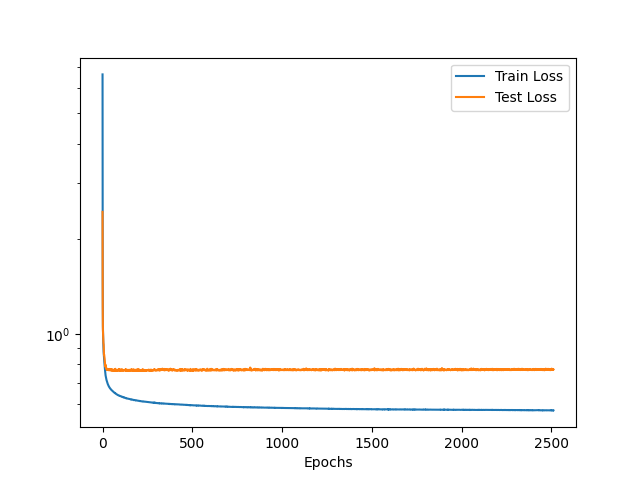

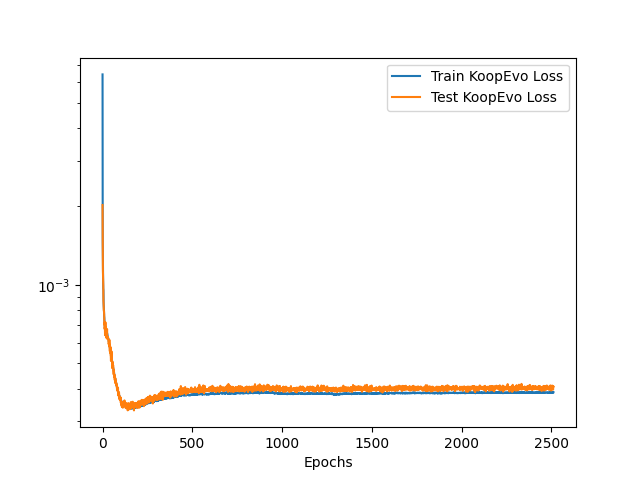

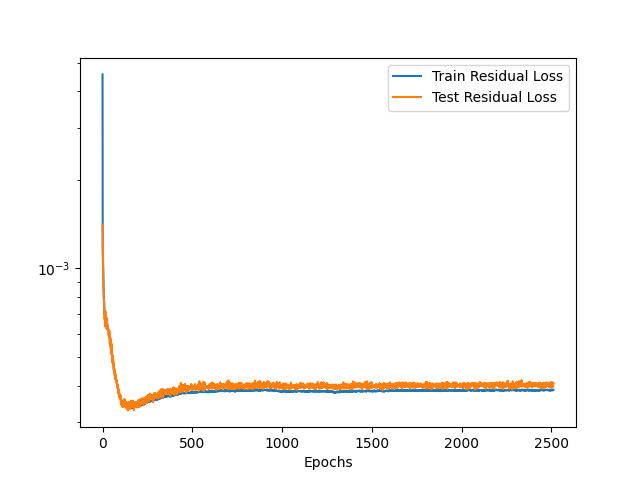

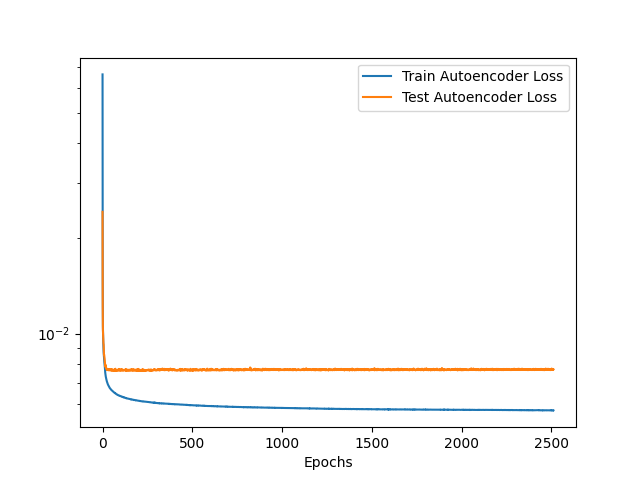

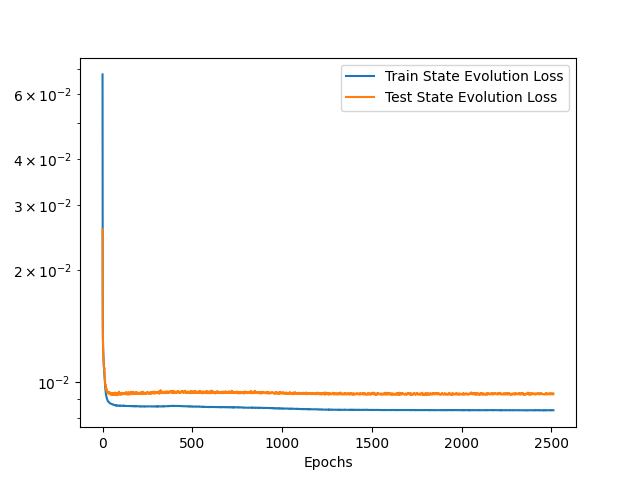

In [36]:
#some stats
print("Deactivate Model: ", models[0].deactivate_seqmodel)
print("Pred horizon: ", models[0].pred_horizon)

#plot learning curves
# plt.figure()
models[0].plot_learning_curves()

Loading Model Weights

In [37]:
#Loading Model Weights
for i in [0]:#range(0,len(models)):
    # if i == 2:
    #     epoch_num = 8000
    #     models[i].load_weights(epoch_num)
    epoch_num = 1000
    models[i].load_weights(epoch_num, min_train_loss = True)

Load Dataset

In [38]:
#Load Dataset

model_num = 0
# models[model_num].data_dir = models[-2].data_dir
models[model_num].load_and_preproc_data()
models[model_num].train_size = 0.5
models[model_num].create_dataset(mode = "Train")
dataset = models[model_num].train_dataset
num_trajs = models[model_num].train_num_trajs

del models[model_num].lp_data

Data Shape:  (8, 5986, 2, 25, 40)
State Dims:  (2, 25, 40)
Not normalizing Input
Train_Shape:  (2, 5986, 2, 25, 40)
Time:  1.2081348896026611


One Step Prediction

In [ ]:

#One Step Prediction
# for i in range(0,len(models)):

ph0 = models[0].pred_horizon 
models[0].pred_horizon = 1

# eval_mza.train_size = 0.9
for i in [0]:#len(models)):
    i=model_num
    
    # del eval_mza.lp_data 
    # torch.cuda.empty_cache()
    # del eval_mza.train_dataset
    # del eval_mza.train_dataloader
    if not models[i].deactivate_seqmodel:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE, koop_out, seqmodel_out = models[i].predict_onestep(dataset, num_trajs)
    else:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE = models[i].predict_onestep(dataset, num_trajs)
    print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)

    #Plotting one step prediction
    x_nn_hat.shape

models[0].pred_horizon = ph0


In [ ]:
Phi = models[0].train_data

In [ ]:
for i in [0]:
    Phi_nn_norm     = np.linalg.norm(np.linalg.norm(np.linalg.norm(Phi_nn.cpu().numpy(), axis = -1), axis = -1),axis = -1)
    Phi_nn_hat_norm = np.linalg.norm(np.linalg.norm(np.linalg.norm(Phi_nn_hat.cpu().numpy(), axis = -1), axis = -1),axis = -1)
    print(Phi_nn_hat_norm.shape)
    plt.figure()
    plt.plot(Phi_nn_norm[0,:], label = "Predicted")
    plt.plot(Phi_nn_hat_norm[0,:], label = "Target")
    plt.legend()

plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")

Multi Step

In [ ]:
for i in range(len(models)):
    models[i].deactivate_seqmodel = False

In [13]:
models[0].deactivate_seqmodel

False

In [39]:
#multistep prediction 1
timesteps = 1000
initial_step = 0
warmup=0
initial_conditions = (torch.from_numpy(models[0].train_data[-1,initial_step,:][None,...]).to(torch.float)).to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat  = torch.zeros((len(models),1,timesteps+1,*models[0].statedim))
Phi_ms_koop = torch.zeros((len(models),1,timesteps,*models[0].statedim))

print("ic shape:", initial_conditions.shape)

for i in [0]:
    x_hat_temp, Phi_ms_hat[i], Phi_ms_koop[i], xkoop_hat_temp, xseq_hat_temp = (models[i].predict_multistep(initial_conditions, timesteps))
    x_ms_hat.append(x_hat_temp)
    xkoop_ms_hat.append(xkoop_hat_temp)
    xseq_ms_hat.append(xseq_hat_temp)
print(Phi_ms_hat.shape, Phi_ms_koop.shape)


ic shape: torch.Size([1, 2, 25, 40])


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([1, 1, 1001, 2, 25, 40]) torch.Size([1, 1, 1000, 2, 25, 40])


In [31]:
#multistep prediction WARMUP
timesteps = 1000
initial_step = 000
warmup = 20
initial_conditions = (torch.from_numpy(models[0].train_data[-1,initial_step:initial_step+warmup,:][None,...]).to(torch.float)).to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat  = torch.zeros((len(models),1,timesteps+2,*models[0].statedim))
Phi_ms_koop = torch.zeros((len(models),1,timesteps+1,*models[0].statedim))

print("ic shape:", initial_conditions.shape)

for i in [0]:
    # x_hat_temp, Phi_ms_hat[i], Phi_ms_koop[i], xkoop_hat_temp, xseq_hat_temp = (models[i].predict_multistep_warmup(initial_conditions, timesteps))
    x_hat_temp, Phi_ms_hat[i] = (models[i].predict_multistep_warmup(initial_conditions, timesteps))
    x_ms_hat.append(x_hat_temp)
    # xkoop_ms_hat.append(xkoop_hat_temp)
    # xseq_ms_hat.append(xseq_hat_temp)
print(Phi_ms_hat.shape, Phi_ms_koop.shape)

ic shape: torch.Size([1, 20, 2, 25, 40])
torch.Size([1, 1, 1002, 2, 25, 40]) torch.Size([1, 1, 1001, 2, 25, 40])


Time averaged Solution

(25, 40) (25, 40)


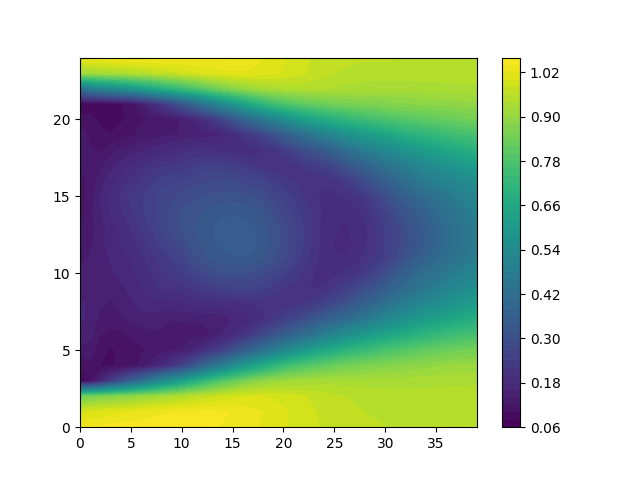

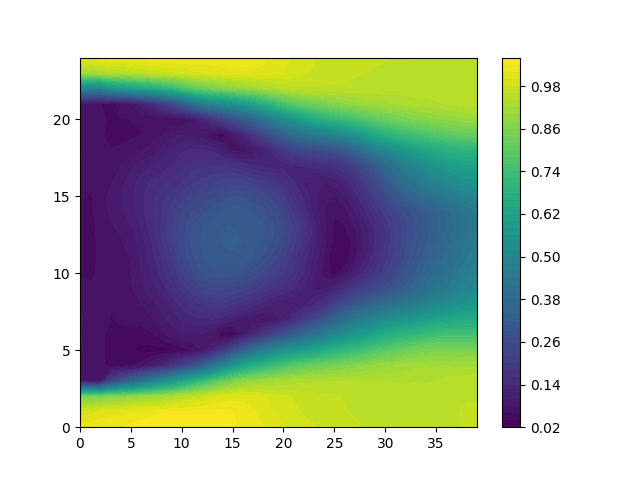

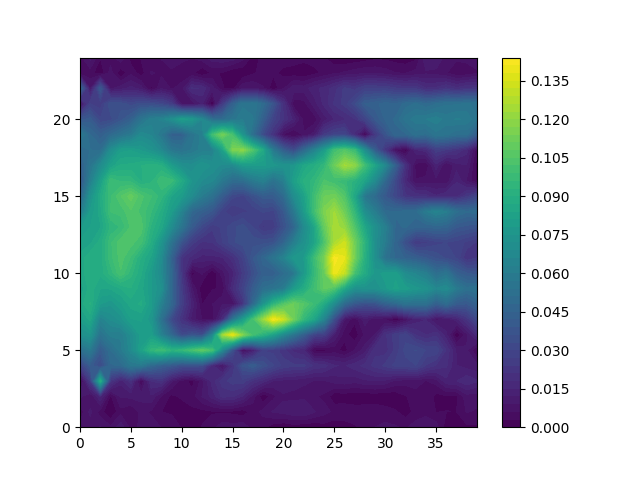

In [40]:
#time averaged solution

x = np.arange(models[0].train_data.shape[-1])
y = np.arange(models[0].train_data.shape[-2])

X,Y = np.meshgrid(x,y)
print(X.shape, Y.shape)

plt.figure()
Z_dns = np.mean(np.linalg.norm(models[0].train_data[-1,initial_step+warmup:timesteps+initial_step+warmup,...], axis = 1), axis = 0)
plt.contourf(X,Y,Z_dns, levels = 50)
plt.colorbar()
plt.show()

plt.figure()
Z_pred = np.mean(np.linalg.norm(Phi_ms_hat[0,0,:timesteps,...].detach().cpu().numpy(), axis = 1), axis = 0)
plt.contourf(X,Y,Z_pred, levels = 50)
plt.colorbar()
plt.show()

plt.figure()
Z_abserr = np.abs((Z_pred - Z_dns))
contour_err = plt.contourf(X,Y,Z_abserr, levels = 50)
# contour_err.set_clim(vmin=0, vmax=200)
cbar = plt.colorbar(contour_err)
# cbar.set_label('Colorbar Label')
plt.show()

Time Averaged Streamline

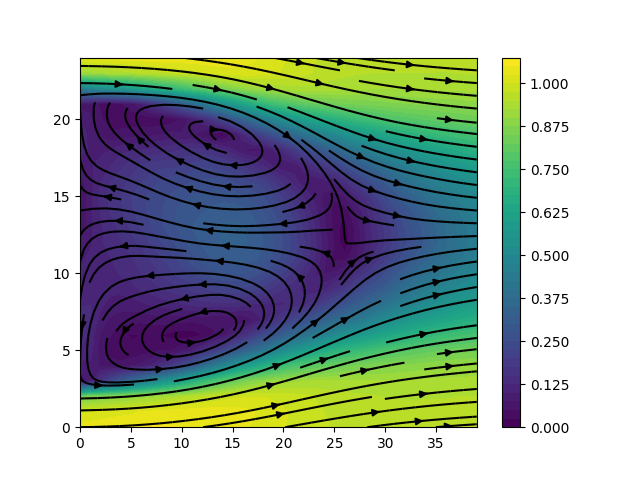

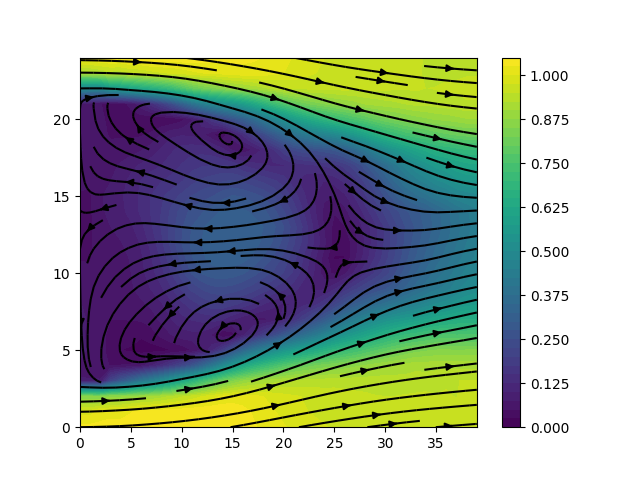

In [41]:

plt.figure()
Z_dns = np.mean(models[0].train_data[-1,initial_step+warmup:timesteps+initial_step+warmup,...], axis = 0)

plt.streamplot(X,Y,Z_dns[0],Z_dns[1], color = "black")
plt.contourf(X,Y,np.linalg.norm(Z_dns, axis=0), levels = 50)
plt.colorbar()

plt.figure()
Z_pred = np.mean(Phi_ms_hat[0,0,:timesteps,...].detach().cpu().numpy(), axis = 0)

plt.streamplot(X,Y,Z_pred[0],Z_pred[1], color = "black")
plt.contourf(X,Y,np.linalg.norm(Z_pred, axis=0), levels=50)
plt.colorbar()



Kinetic Energy

(400,)


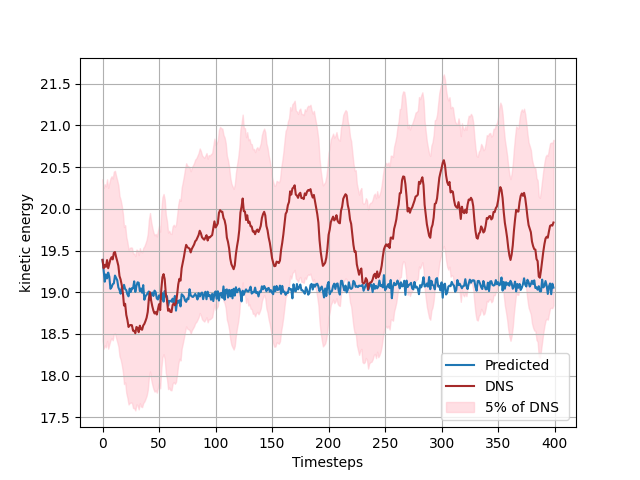

In [42]:
#kinetic energy of multistep rpediciton
def KS_kinetic_energy(Phi):
    k = np.linalg.norm(np.linalg.norm(np.linalg.norm(Phi, axis = -1), axis = -1),axis = -1)
    return k

plt.figure()

timesteps_ke = 400
timesteps_dns = 400
# lt = 93.024
# x = np.arange(timesteps_ke)/lt
# x_dns = np.arange(timesteps_dns)/lt

for i in [0]:
    
    plt.plot(KS_kinetic_energy(Phi_ms_hat[i,0,:timesteps_ke].detach().cpu().numpy()),"-", label = "Predicted")#f"Memory Length {round((models[i].seq_len - 1)/lt,2)}")

dns_ke_plot = KS_kinetic_energy(models[0].train_data[-1,initial_step+warmup:timesteps_dns+initial_step+warmup])
print(dns_ke_plot.shape)
plt.plot(dns_ke_plot, label = "DNS",color = "brown")
plt.fill_between(np.arange(dns_ke_plot.shape[0]),dns_ke_plot - dns_ke_plot*0.05, dns_ke_plot + dns_ke_plot*0.05, color='pink', alpha=0.5, label='5% of DNS ')

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

plt.grid()


(25, 40) (25, 40)


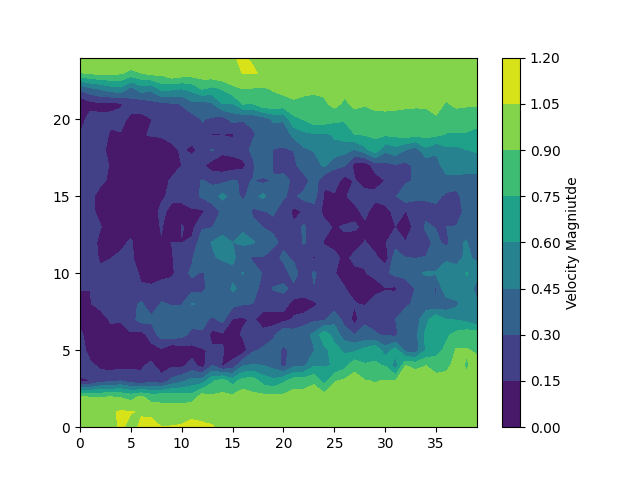

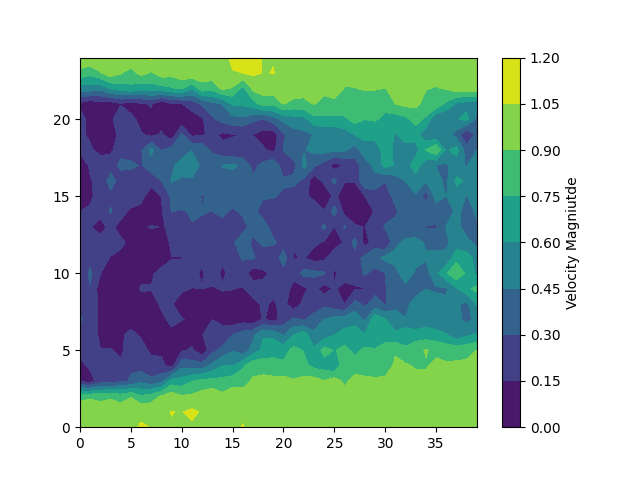

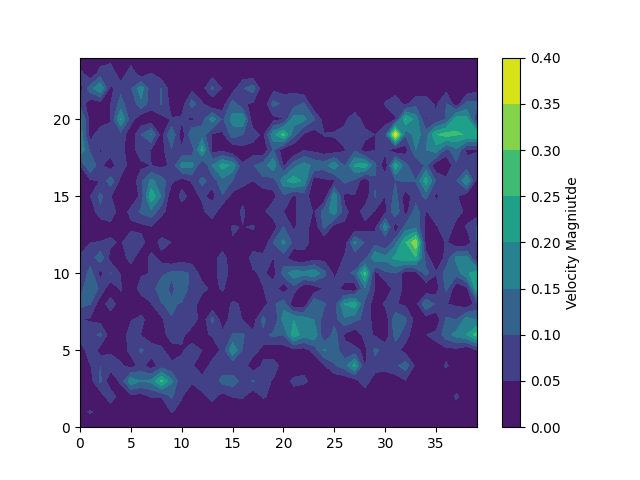

In [43]:
x = np.arange(models[0].train_data.shape[-1])
y = np.arange(models[0].train_data.shape[-2])

X,Y = np.meshgrid(x,y)
print(X.shape, Y.shape)

######################################################################
# plt.contourf(X,Y,data[1,1,0,...])
fig, ax = plt.subplots()
Z = np.linalg.norm(models[0].train_data[-1,initial_step+warmup-1,...], axis=0) # Update the data for the new frame
contour = ax.contourf(X, Y, Z, cmap='viridis')

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Velocity Magniutde')

def update1(frame):
    ax.cla()  # Clear the previous frame
    Z = np.linalg.norm(models[0].train_data[-1,frame+initial_step+warmup-1,...], axis=0) # Update the data for the new frame
    contour = ax.contourf(X, Y, Z, levels=20)
    return contour

ani = FuncAnimation(fig, update1, frames=500, repeat=False)

# ani.save('dns.gif', writer='imagemagick')
# plt.show()
# ani.save("DNS_full.gif")

######################################################################
fig2, ax2 = plt.subplots()
Z = np.linalg.norm(Phi_ms_hat[0,0,0,...], axis = 0) # Update the data for the new frame
contour = ax2.contourf(X, Y, Z, cmap='viridis')

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax2)
cbar.set_label('Velocity Magniutde')

def update2(frame):
    ax2.cla()  # Clear the previous frame
    Z = np.linalg.norm(Phi_ms_hat[0,0,frame,...], axis = 0) # Update the data for the new frame
    contour = ax2.contourf(X, Y, Z, levels=20)
    return contour

ani2 = FuncAnimation(fig2, update2, frames=500, repeat=False)

# ani2.save('prediction128.gif', writer='imagemagick')

######################################################################
fig3, ax3 = plt.subplots()
Z_dns = np.linalg.norm(models[0].train_data[-1,1,...], axis=0)
Z_pred = np.linalg.norm(Phi_ms_hat[0,0,1,...], axis = 0)
Z = np.abs(Z_dns-Z_pred) # Update the data for the new frame
contour = ax3.contourf(X, Y, Z, cmap='viridis')

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax3)
cbar.set_label('Velocity Magniutde')

def update3(frame):
    ax3.cla()  # Clear the previous frame
    Z_dns = np.linalg.norm(models[0].train_data[-1,frame,...], axis=0)
    Z_pred = np.linalg.norm(Phi_ms_hat[0,0,frame,...], axis = 0)
    Z = np.abs(Z_dns-Z_pred) # Update the data for the new frame
    contour = ax3.contourf(X, Y, Z, levels=20)
    return contour

ani3 = FuncAnimation(fig3, update3, frames=500, repeat=False)
# ani3.save('error128.gif', writer='imagemagick')

Instantaneous Streamline

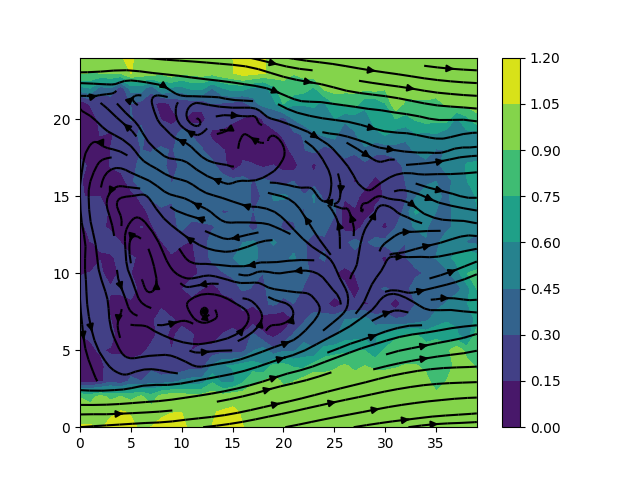

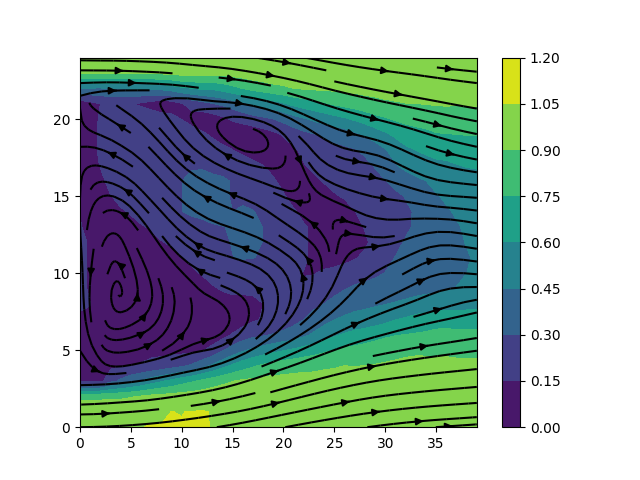

In [44]:
st_timestep = 20
plt.figure()
plt.streamplot(X,Y,models[0].train_data[-1,st_timestep,0],models[0].train_data[-1,st_timestep,1], color = "black")
plt.contourf(X,Y,np.linalg.norm(models[0].train_data[-1,st_timestep,...], axis=0))
plt.colorbar()

plt.figure()
plt.streamplot(X,Y,Phi_ms_hat[0,0,st_timestep,0],Phi_ms_hat[0,0,st_timestep,1], color = "black")
plt.contourf(X,Y,np.linalg.norm(Phi_ms_hat[0,0,st_timestep], axis=0))
plt.colorbar()



Energy spectrum

In [53]:
models[0].train_data.shape

(2, 5986, 2, 50, 79)

Text(0, 0.5, 'E(k)')

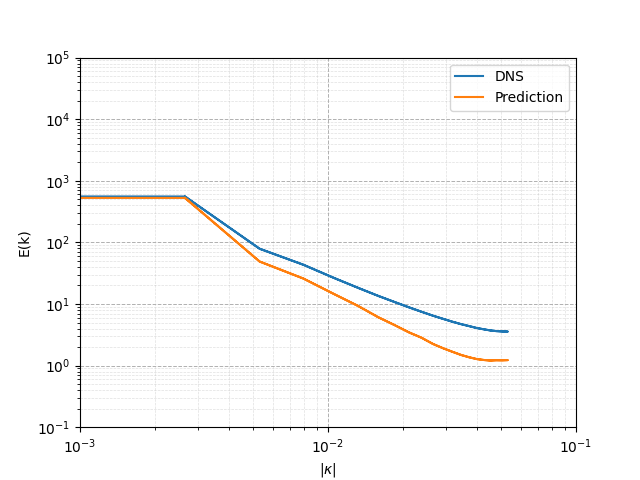

In [45]:
# #energy spectrum

def energy_spectrum(Phi_ms_hat_forfft):

    Phi_ms_hat_fft = np.fft.fft2(Phi_ms_hat_forfft)
    # print(Phi_ms_hat_fft.shape)
    k_fft = np.mean(np.mean(np.mean(np.abs(Phi_ms_hat_fft)**2,axis = 1), axis = 0),axis = -2)
    # print(k_fft.shape)
    kappa = np.fft.fftfreq(k_fft.shape[0], d=1/0.106)
    # print(kappa.shape)

    return k_fft, kappa

k_fft_dns, kappa  = energy_spectrum(models[0].train_data[-1])
k_fft_pred, kappa = energy_spectrum(Phi_ms_hat[0,0].detach().cpu().numpy())

plt.figure()
plt.loglog(np.abs(kappa), k_fft_dns, label = f"DNS")
plt.loglog(np.abs(kappa), k_fft_pred, label = f"Prediction")

plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.minorticks_on()  # Enable minor ticks for both axes
plt.grid(True, which="minor", linestyle="--", alpha=0.4, linewidth=0.5)

plt.xlim(1e-3,1e-1)
plt.ylim(1e-1,1e5)
plt.xlabel(r"$|\kappa|$")
plt.ylabel(r"E(k)")


Power Spctrum Density


(1001, 2, 25, 40)
(1001,)


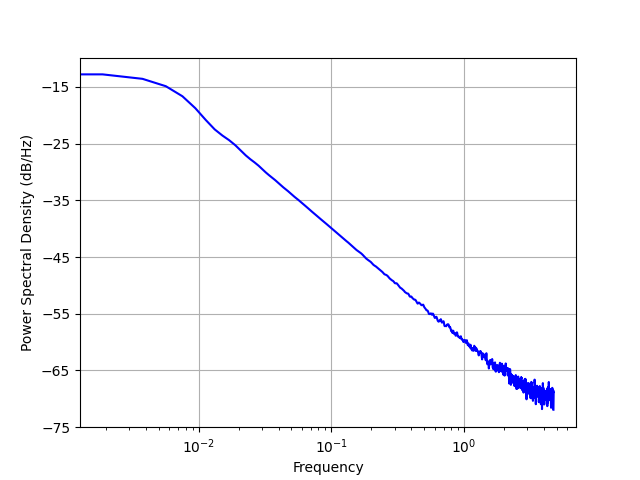

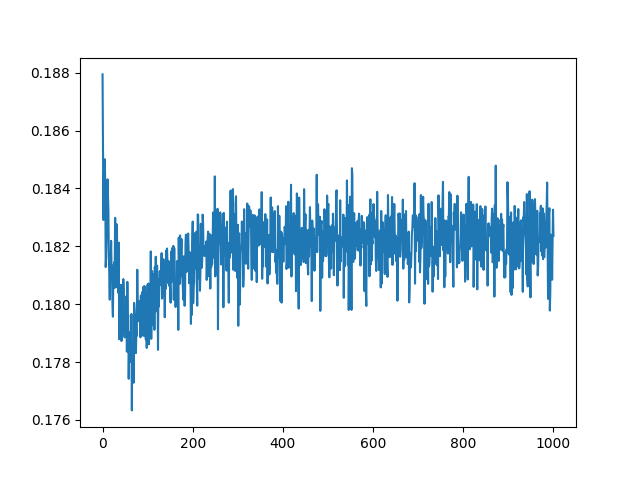

In [46]:
import scipy
Phi_ms_hat_forfft = Phi_ms_hat[0,0].detach().cpu().numpy() #models[0].train_data[-1]#models[0].train_data[-1]#
print(Phi_ms_hat_forfft.shape)
ke = np.mean(np.mean(np.mean(Phi_ms_hat_forfft**2, axis=1), axis = 1), axis=1)
print(ke.shape)
plt.figure()
plt.plot(ke)

plt.figure()
plt.psd(ke, Fs=1/0.106, NFFT=5000, color='blue')

# plt.semilogy(f, ps)
plt.xscale('log')
plt.show()

# plt.ylim([1e-7, 1e2])
# ps = np.abs(np.fft.rfft(ke, axis=0)**2)
# print(ps.shape)

# time_step = 1/0.106
# freqs = np.fft.rfftfreq(Phi_ms_hat_forfft.shape[0], time_step)
# idx = np.argsort(freqs)

# print(freqs.shape, freqs)
# plt.figure()
# plt.plot(freqs[idx], ps[idx])
# plt.ylim(0,0.2)

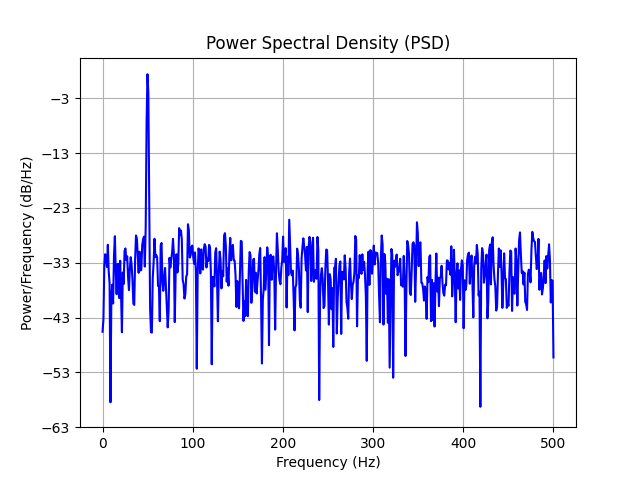

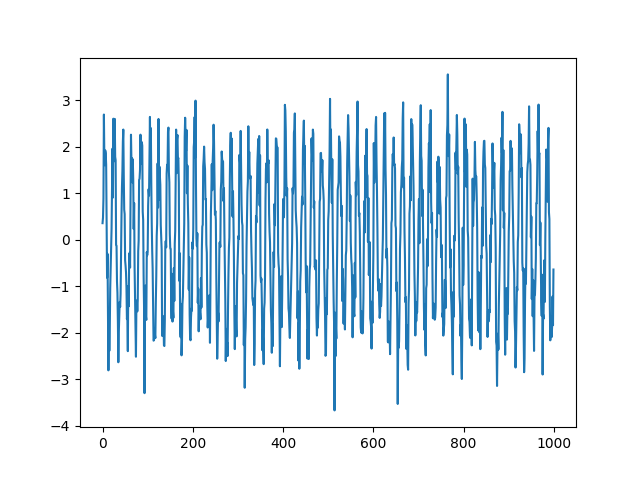

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a sample signal
fs = 1000  # Sampling frequency
t = np.arange(0, 1, 1/fs)  # Time vector
signal = 2 * np.sin(2 * np.pi * 50 * t) + 0.5 * np.random.randn(len(t))  # Signal with noise

plt.figure()
plt.plot(signal)
# Plot the power spectral density
plt.figure()
plt.psd(signal, Fs=fs, NFFT=1024, color='blue')

# Set labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density (PSD)')

# Show the plot
plt.show()

Latent Space Analysis


Text(0, 0.5, '$\\mathcal{K}(x_{2})$')

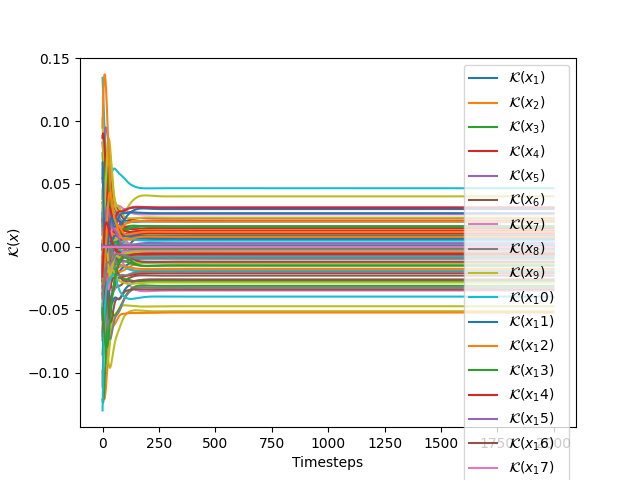

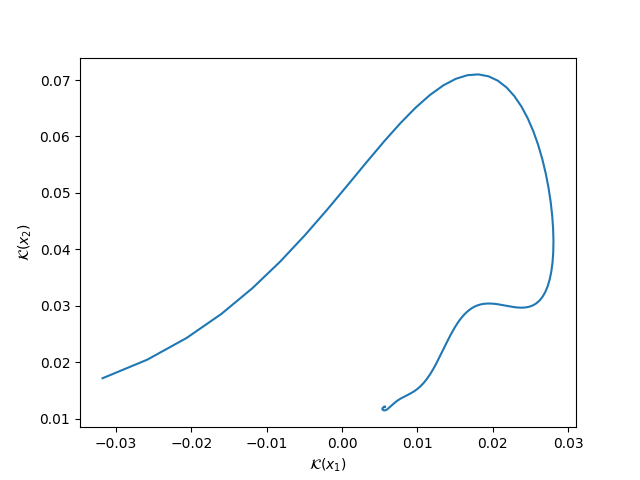

In [52]:
#plotting koopman mode evolution
plt.figure()
model_num = 0
for n in range(models[model_num].num_obs):
    plt.plot(xkoop_ms_hat[model_num][0,:,n].cpu().numpy(), label = r"$\mathcal{K}$"+f"$(x_{n+1})$")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel(r"$\mathcal{K}(x)$")

plt.figure()
# plt.gca().set_aspect('equal')
plt.plot(xkoop_ms_hat[model_num][0,:,0].cpu().numpy(), xkoop_ms_hat[model_num][0,:,2].cpu().numpy())

plt.xlabel(r"$\mathcal{K}(x_{1})$")
plt.ylabel(r"$\mathcal{K}(x_{2})$")

Text(0, 0.5, 'Observables  $  L_{2}$ Norm')

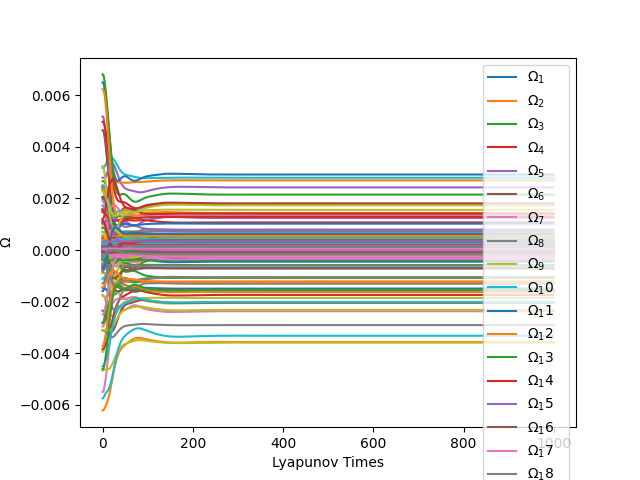

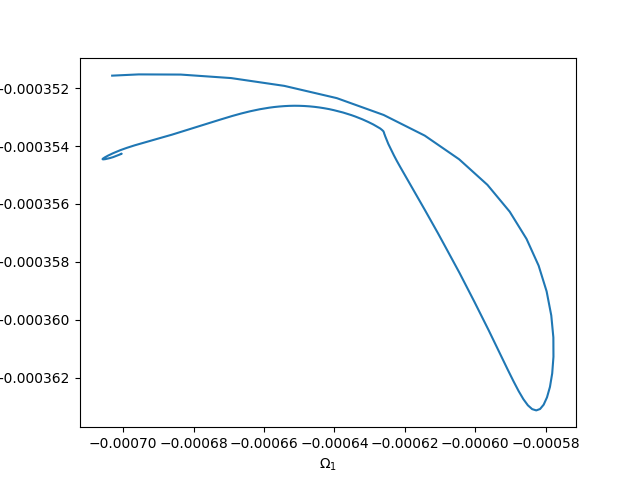

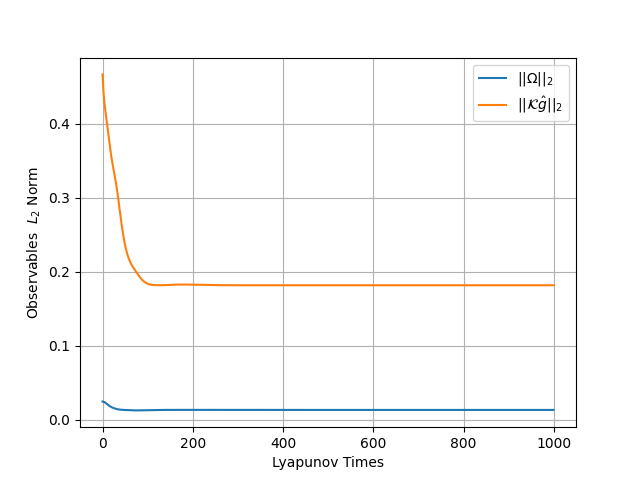

In [53]:
#plotting seqmodel mode evolution
plt.figure()
timesteps_ke = 1000
x = np.arange(timesteps_ke)

model_num = 0
tgt_xseq_ms_hat = xseq_ms_hat[model_num].cpu().numpy()
tgt_xkoop_ms_hat = xkoop_ms_hat[model_num].cpu().numpy()
for n in range(models[model_num].num_obs):
    plt.plot(x, xseq_ms_hat[model_num][0,:timesteps_ke,n].cpu().numpy(), label = r"$\Omega$"+f"$_{n+1}$")

plt.legend()
plt.xlabel("Lyapunov Times")
plt.ylabel(r"$\Omega$")

plt.figure()
# plt.gca().set_aspect('equal')
plt.plot(xseq_ms_hat[model_num][0,:timesteps_ke,0].cpu().numpy(), xseq_ms_hat[model_num][0,:timesteps_ke,1].cpu().numpy())
plt.xlabel(f"$\Omega_{1}$")
plt.ylabel(f"$\Omega_{2}$")

plt.figure(dpi = 100)
tgt_xseq_norm = np.linalg.norm(tgt_xseq_ms_hat, axis = -1)
tgt_xkoop_norm = np.linalg.norm(tgt_xkoop_ms_hat, axis = -1)


# plt.plot((tgt_xseq_norm/np.max(tgt_xseq_norm, axis = -1))[0,:], label = r"$||\Omega||_{2}$")
# plt.plot((tgt_xkoop_norm/np.max(tgt_xkoop_norm, axis = -1))[0,:], label = r"$||\mathcal{K}(x)||_{2}$")

plt.plot(x, (tgt_xseq_norm)[0,:timesteps_ke], label = r"$||\Omega||_{2}$")
plt.plot(x, (tgt_xkoop_norm)[0,:timesteps_ke], label = r"$||\mathcal{K}\hat{g}||_{2}$")



plt.legend(loc = "upper right")
plt.xlabel("Lyapunov Times")
plt.grid("on")
plt.ylabel("Observables  " + r"$  L_{2}$" +  " Norm")



In [ ]:
import scipy

data = tgt_xkoop_norm.T
ps = np.abs(np.fft.fft(data))**2

print(ps.shape)
time_step = 1 / 4
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

plt.figure()
plt.plot(freqs[idx], ps[idx])


data = tgt_xseq_norm.T
ps = np.abs(np.fft.fft(data))**2

print(ps.shape)
time_step = 1 / 4
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

plt.figure()
plt.plot(freqs[idx], ps[idx])
# plt.semilogy(f, S)
# plt.xlim([0, fs])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
# plt.show()

In [ ]:
plt.figure()
plt.plot(tgt_xseq_norm.squeeze(), tgt_xkoop_norm.squeeze(), ".")

In [ ]:
#CCF 1
tgt_xseq_norm_p = tgt_xseq_norm[0,:]
import pandas as pd
import statsmodels.tsa.stattools 
 

# plot the auto correlation
plt.figure()
plt.plot(statsmodels.tsa.stattools.ccf(tgt_xseq_norm.squeeze(), tgt_xkoop_norm.squeeze()))
statsmodels.tsa.stattools.ccf(tgt_xseq_norm.squeeze(), tgt_xkoop_norm.squeeze()).shape

In [ ]:
#CCF2
from scipy import signal

def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c
    
ccf = ccf_values(tgt_xseq_norm.squeeze(), tgt_xkoop_norm.squeeze())
ccf

lags = signal.correlation_lags(len(tgt_xseq_norm.squeeze()), len(tgt_xseq_norm.squeeze()))

def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correation Koopman norm and Memory Model norm', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    plt.xlim(-100,100)

ccf_plot(lags, ccf)

In [ ]:
print(Phi_nn.shape, Phi_ms_hat.shape)
timesteps_mse = 1000
State_MSE_multistep = torch.zeros((len(models),timesteps_mse))

x = np.arange(timesteps_mse)/lt
plt.figure()
for i in [0,1,2,3,4]:#range(len(models)-3):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps_mse],Phi_ms_hat[i,:,:timesteps_mse]).detach().cpu()
    # if i!=len(models)-1:
    
    plt.semilogy(x, State_MSE_multistep[i].numpy(), label = f" Seq Length {models[i].seq_len - 1}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")

# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.legend()
plt.xlabel("Lyapunov Time")
plt.ylabel("MSE")
# np.save("koopman_numobs32.npy",Phi_hat.cpu().numpy())

In [ ]:
#calculating kinetic energy for multistep prediction
k_ms_pred = energy(U_ms_hat, V_ms_hat)
print(k_ms_pred.shape)
plt.figure()
for i in [0,1,2,3,4,5,6,7]:
    
    plt.plot(k_ms_pred[i,0,:], label = f"Number of Hidden Units {models[i].seq_len}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(k[0,initial_step:], label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

Jacobian Analysis

In [ ]:
#multistep prediction
timesteps_jac = 200
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat = torch.zeros((len(models),1,timesteps_jac+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps_jac,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

grad_xn_xseq = []

for i in [0,1,2,3,4]:#range(len(models)):
    
    grad_xn_xseq.append(models[i].jacobian_calc(initial_conditions, timesteps_jac))
    n = torch.mean(torch.norm(grad_xn_xseq[i].cpu(), dim = -1),dim = 1)
    print(i, n.shape)

print(grad_xn_xseq[0].shape)

In [ ]:
x = torch.arange(timesteps_jac)/lt
print(x[:].shape)
plt.figure()
for i in [0,1,2,3,4]:#range(len(models)):
    
    n = torch.mean(torch.norm(grad_xn_xseq[i].cpu(), dim = -1),dim = 1)
    print(i, n.shape)
    inv_n = torch.flip(n,[1])
    inv_x = torch.flip(x,[0])
    plt.plot( inv_n[0,:], ".-", label = f"Memory length {models[i].seq_len - 1}")
plt.legend()
plt.gca().invert_xaxis()
plt.gca().set_xticklabels([-tick for tick in plt.gca().get_xticks()])
plt.ylabel("Time Averaged Jacobian Norm")
plt.xlabel("Timesteps")

In [ ]:


w, v = np.linalg.eig(grad_xn_xseq[0].cpu().numpy())

idx = w.argsort()[::-1]
w = w[idx]
v = v[:,idx]

print(w)

Eigenvalue Study

[ 9.69142318e-01+0.00000000e+00j  9.66700554e-01+1.56479497e-02j
  9.66700554e-01-1.56479497e-02j  9.42725658e-01+1.33079574e-01j
  9.42725658e-01-1.33079574e-01j  9.40519750e-01+2.29713181e-03j
  9.40519750e-01-2.29713181e-03j  9.25001204e-01+3.50904390e-02j
  9.25001204e-01-3.50904390e-02j  9.21614885e-01+6.30391315e-02j
  9.21614885e-01-6.30391315e-02j  9.19266820e-01+0.00000000e+00j
  9.05074477e-01+0.00000000e+00j  8.98340344e-01+0.00000000e+00j
  8.49606395e-01+2.18386263e-01j  8.49606395e-01-2.18386263e-01j
  8.39405060e-01+1.65389940e-01j  8.39405060e-01-1.65389940e-01j
  8.11851859e-01+0.00000000e+00j  8.80163349e-03+0.00000000e+00j
  3.34862480e-03+0.00000000e+00j  2.28713034e-03+0.00000000e+00j
  2.26912042e-03+5.12671657e-04j  2.26912042e-03-5.12671657e-04j
  1.44103146e-03+0.00000000e+00j  1.09361461e-03+1.97261965e-04j
  1.09361461e-03-1.97261965e-04j  6.41389517e-04+9.31727991e-05j
  6.41389517e-04-9.31727991e-05j  6.28275331e-04+3.52831470e-04j
  6.28275331e-04-3.528314

Text(0, 0.5, '$Img(\\lambda)$')

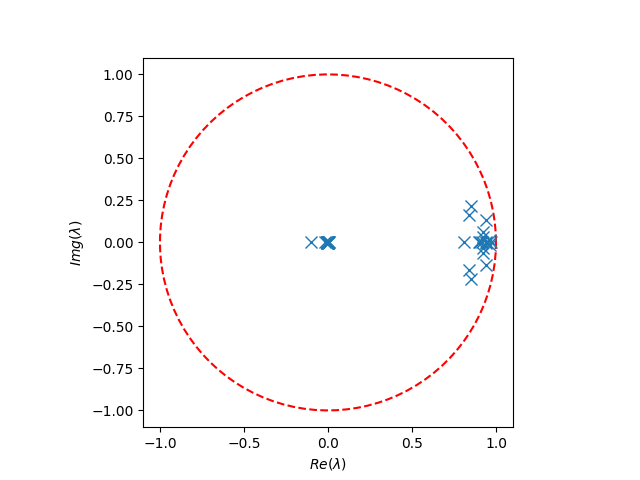

In [29]:
#eigenvalue study
plt.figure()
plt.gca().set_aspect('equal')

angles = np.linspace(0, 2 * np.pi, 100)
unit_circle = np.exp(1j * angles)
plt.plot(unit_circle.real, unit_circle.imag, '--', color = 'red', label = "Unit Circle")

for i in [-1]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    print(w)
    # plt.matshow(mat)
    # plt.colorbar()
    # plt.figure()
    plt.plot(np.real(w), np.imag(w), "x", markersize = 9, label = f"Num Observables {models[i].num_obs}")

plt.xlabel(r"$Re(\lambda)$")
plt.ylabel(r"$Img(\lambda)$")
# plt.legend()

array([-1.86444492e+01-2.9329085j , -1.86444492e+01+2.9329085j ,
       -1.80257893e+01+1.6562876j , -1.80257893e+01-1.6562876j ,
       -1.69489651e+01+1.7840381j , -1.69489651e+01-1.7840381j ,
       -1.61723785e+01-3.5830498j , -1.61723785e+01+3.5830498j ,
       -1.60263214e+01-0.72005355j, -1.60263214e+01+0.72005355j,
       -1.56035910e+01-2.2320683j , -1.56035910e+01+2.2320683j ,
       -1.54580498e+01+4.7169814j , -1.54404411e+01-3.4174192j ,
       -1.54404411e+01+3.4174192j , -1.54294090e+01-4.170208j  ,
       -1.54294090e+01+4.170208j  , -1.52537813e+01+1.0497261j ,
       -1.52537813e+01-1.0497261j , -1.50472183e+01+0.j        ,
       -1.47551050e+01-2.3527627j , -1.47551050e+01+2.3527627j ,
       -1.46961184e+01-3.281318j  , -1.46961184e+01+3.281318j  ,
       -1.46345749e+01-0.3293398j , -1.46345749e+01+0.3293398j ,
       -1.45839567e+01-3.7740142j , -1.45839567e+01+3.7740142j ,
       -1.45337515e+01-4.3723316j , -1.45337515e+01+4.3723316j ,
       -1.44347649e+01-2.

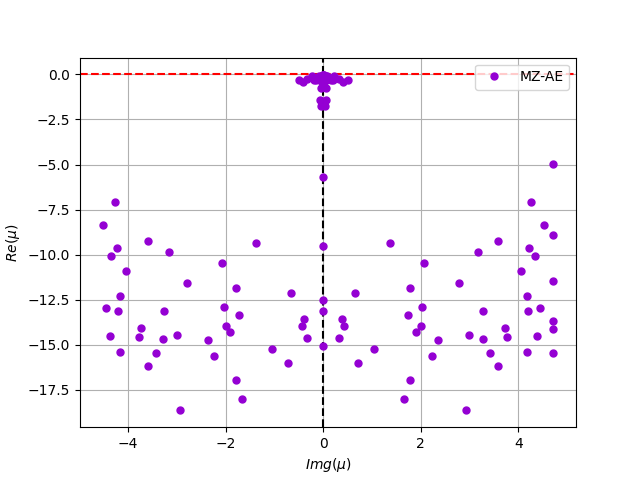

In [47]:
import copy
plt.figure()

plt.axhline(0, color='red', linestyle='--')
plt.axvline(x=0, color='black', linestyle='--')

U_inf = 15 #m/s
D     = 0.1965 #m/s 
# plt.text(0.17, 0.075, 'x = 0.17', color='green')
for i in [0]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = np.abs(w).argsort()
    w = w[idx]
    v = v[:,idx]

    lamb = (np.log(w)/0.106)

    lamb = lamb/(2*np.pi)

    plt.plot(np.imag(lamb[:]),np.real(lamb[:]),".", color = "darkviolet", markersize = 10, label = "MZ-AE")
    lamb_mzae = copy.deepcopy(lamb)

plt.ylabel(r"$Re(\mu)$")
plt.xlabel(r"$Img(\mu)$")
plt.grid("on")
# plt.ylim(-0.15,0.1)
# plt.xlim(-1,1)
plt.legend(loc = "upper right")
lamb


In [ ]:
#Matrix
plt.figure()


for i in [0]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    plt.matshow(mat)
    plt.colorbar()
    # plt.figure()
    # plt.plot(np.real(w), np.imag(w), ".", label = f"Num Observables {models[i].num_obs}")
    print(mat)
# plt.legend()

FREQUENCY RESPONSE ANALYSIS

In [ ]:
import scipy
A = 0.1

T = 10 #Final timestep
dt = 0.25 #timesample size
t_set = np.arange(0,T,dt)
w_set = np.logspace(np.log10(1/T),np.log10(0.5*(1/dt)),120)
print(w_set)

ist_set = torch.zeros((1,1,models[0].num_obs))
ost_set = torch.zeros((1,1,models[0].num_obs))

input_signal  = torch.zeros((1,1,len(t_set),models[0].num_obs)) #[bs num_freq num_timesamples, num_obs]
output_signal = torch.zeros((1,1,len(t_set),models[0].num_obs)) #[bs num_freq num_timesamples, num_obs]

# input_signal_t  = torch.zeros((1,1,len(t_set),models[0].num_obs)) #[bs num_freq num_timesamples, num_obs]
# output_signal_t = torch.zeros((1,1,len(t_set),models[0].num_obs)) #[bs num_freq num_timesamples, num_obs]

for w in w_set:#range(models[0].num_obs):
    for t in t_set:
        ist = torch.eye(models[0].num_obs)[i]*t
        # print(ist)
        ist = ist[None,None,...] 
        ist = A*np.sin(w*ist)
        ost = models[0].model.seqmodel(ist.to(models[0].device))[None,...]
        # print(ost.shape)

        if t == 0:
            ist_set = ist
            ost_set = ost
        else:
            ist_set = torch.concat((ist_set,ist),axis = 1)  
            ost_set = torch.concat((ost_set,ost),axis = 1)  
        
        # ist = ist[None,None,...] #[bs(1) timeseq(1) numobs]
    if i == 0:
        input_signal_t  = ist_set[None,...]
        output_signal_t = ost_set[None,...]
    else:
        input_signal_t  = torch.concat((input_signal_t,  ist_set[None,...]), axis=1)
        output_signal_  = torch.concat((output_signal_t, ost_set[None,...]), axis=1)

    input_signal = torch.concat((input_signal, input_signal_t.to("cpu")), axis=0)
    output_signal = torch.concat((output_signal, output_signal_t.to("cpu")), axis=0)

input_signal = input_signal[1:,...]
output_signal = output_signal[1:,...]
print(output_signal.shape)
print(input_signal.shape)

cat = torch.concat((input_signal, output_signal), axis = 0).detach().numpy()
cat = {"input":input_signal.to("cpu").detach().numpy(),"output":output_signal.to("cpu").detach().numpy(), "time": t_set}


from scipy.io import savemat

# Specify the MAT file path
mat_file_path = 'test_freq.mat'

# Save the dictionary of NumPy arrays as a MAT file
savemat(mat_file_path, cat)

print(f'Data saved to {mat_file_path}')